In [19]:
import tensorflow as tf
import numpy as np
import pandas as pd
import sklearn
import keras
import matplotlib.pyplot as plt
import pydot
import VisualizeNN as VisNN

from sklearn.model_selection import train_test_split, KFold
from privacy.analysis.rdp_accountant import compute_rdp
from privacy.analysis.rdp_accountant import get_privacy_spent
import privacy
print(tf.__version__)
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

1.14.0


In [2]:
data = pd.read_csv("datasets/hmda_VA_nolog_clean.csv")
dataevensamp = pd.concat([(data[data["action_taken_name"] == 1]).sample(n=len(data[data["action_taken_name"]==0])),
                          data[data["action_taken_name"]==0]])
data = dataevensamp.sample(frac=1).iloc[:,1:]
data.head()

,tract_to_msamd_income,population,minority_population,number_of_owner_occupied_units,number_of_1_to_4_family_units,loan_amount_000s,hud_median_family_income,applicant_income_000s,property_type_name,owner_occupancy_name,loan_type_name,loan_purpose_name,lien_status_name,co_applicant_sex_name,applicant_sex_name,applicant_race_name_1,applicant_ethnicity_name,agency_abbr,action_taken_name
187938,0.308537,0.391812,0.331399,0.410450,0.414694,0.000050,0.362799,0.000503,1,0,1,0,0,1,1,1,1,1,0
199496,0.265901,0.249033,0.406944,0.354936,0.244083,0.000525,1.000000,0.000075,1,1,0,1,1,1,1,1,1,1,0
176264,0.308272,0.607509,0.121273,0.799297,0.814159,0.000484,0.383057,0.000386,1,1,0,0,1,0,1,1,1,1,1
167833,0.318060,0.215968,0.112568,0.257975,0.249640,0.000106,1.000000,0.000469,1,1,1,0,0,0,1,1,1,1,0
200541,0.210259,0.261321,0.756254,0.149209,0.226384,0.000463,0.362799,0.000361,1,1,0,0,1,0,0,0,1,1,0


In [3]:
#data[['tract_to_msamd_income', 'population', 'minority_population', 'number_of_owner_occupied_units','number_of_1_to_4_family_units','loan_amount_000s','hud_median_family_income', 'applicant_income_000s']].hist(bins=100, figsize=(15, 15))

In [4]:
# MaxMinScaling
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler(feature_range = (0, 1))
#data[['tract_to_msamd_income', 'population', 'minority_population', 'number_of_owner_occupied_units','number_of_1_to_4_family_units','loan_amount_000s','hud_median_family_income', 'applicant_income_000s']] = scaler.fit_transform(data[['tract_to_msamd_income', 'population', 'minority_population', 'number_of_owner_occupied_units','number_of_1_to_4_family_units','loan_amount_000s','hud_median_family_income', 'applicant_income_000s']])

In [5]:
#data[['tract_to_msamd_income', 'population', 'minority_population', 'number_of_owner_occupied_units','number_of_1_to_4_family_units','loan_amount_000s','hud_median_family_income', 'applicant_income_000s']].hist(bins=100, figsize=(15, 15))

In [6]:
predictors = data.iloc[:,0:-1].values
labels = pd.to_numeric(data.iloc[:,-1], downcast='integer').values
from keras.utils import to_categorical
#labels = to_categorical(labels)
x_train, x_test, y_train, y_test = train_test_split(predictors, labels, test_size=.2)
y_train

array([1, 0, 1, ..., 1, 0, 0], dtype=int8)

In [7]:
# 1. INSTANTIATE
#enc = sklearn.preprocessing.OneHotEncoder()

# 2. FIT
#enc.fit(data.drop(['approved'], axis=1))

# 3. Transform
#onehotlabels = enc.transform(data.drop(['approved'], axis=1)).toarray()
#predictors = pd.DataFrame(onehotlabels).values
#labels = pd.to_numeric(data.iloc[:,-1], downcast='integer').values

#x_train, x_test, y_train, y_test = train_test_split(onehotlabels, labels, test_size=.2)

In [8]:
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    keras.backend.get_session().run(tf.local_variables_initializer())
    return auc

In [16]:
def model_creation(optimizer='adam', loss='binary_crossentropy'):    
    model = keras.models.Sequential([
        #keras.layers.Dense(100, activation=tf.nn.relu, input_shape=(x_train.shape[1],)),
        keras.layers.Dense(8, activation=tf.nn.relu),
        keras.layers.Dense(4, activation=tf.nn.relu),
        keras.layers.Dense(1, activation=tf.nn.sigmoid)
    ])
    model.compile(optimizer=optimizer,
             loss=loss,
             metrics=['accuracy', auc])
    return model

In [70]:
model = model_creation()
model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))
model.summary()

Train on 64787 samples, validate on 16197 samples
Epoch 1/5
64787/64787 [==============================] - 8s 128us/step - loss: 0.6126 - acc: 0.6764 - auc: 0.6788 - val_loss: 0.5948 - val_acc: 0.6924 - val_auc: 0.7291
Epoch 2/5
64787/64787 [==============================] - 6s 91us/step - loss: 0.5917 - acc: 0.6961 - auc: 0.7373 - val_loss: 0.5904 - val_acc: 0.6943 - val_auc: 0.7414
Epoch 3/5
64787/64787 [==============================] - 5s 84us/step - loss: 0.5876 - acc: 0.6979 - auc: 0.7444 - val_loss: 0.5871 - val_acc: 0.6941 - val_auc: 0.7468
Epoch 4/5
64787/64787 [==============================] - 6s 96us/step - loss: 0.5856 - acc: 0.6973 - auc: 0.7485 - val_loss: 0.5854 - val_acc: 0.6961 - val_auc: 0.7499
Epoch 5/5
64787/64787 [==============================] - 6s 86us/step - loss: 0.5842 - acc: 0.6967 - auc: 0.7510 - val_loss: 0.5843 - val_acc: 0.6961 - val_auc: 0.7520
_________________________________________________________________
Layer (type)                 Output Shape  

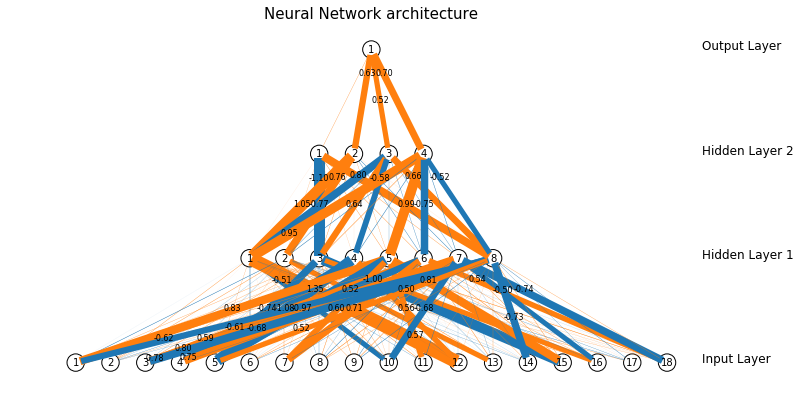

In [78]:
layer_weights = []
network_structure = [x_test.shape[1]]
for layer in model.layers:
    layer_weights.append(layer.get_weights()[0])
    network_structure.append(layer.output_shape[1])
network = VisNN.DrawNN(network_structure, layer_weights)
network.draw()

8
4
1


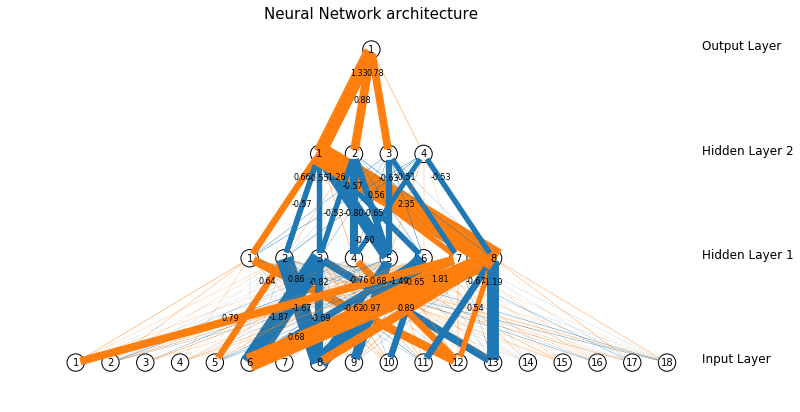

In [69]:
layer_weights = []
network_structure = [x_test.shape[1]]
for layer in model.layers:
    print(layer.output_shape[1])
    #print(layer.get_weights()[0])
    layer_weights.append(layer.get_weights()[0])
    network_structure.append(layer.output_shape[1])
network = VisNN.DrawNN(network_structure, layer_weights)
network.draw()

8
4
1


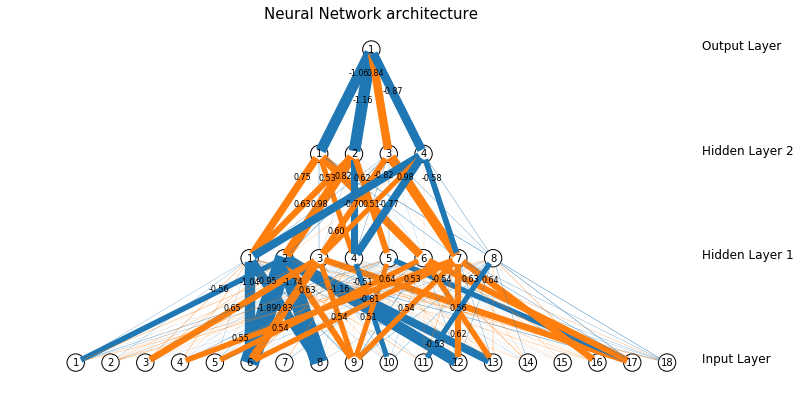

In [71]:
layer_weights = []
network_structure = [x_test.shape[1]]
for layer in model.layers:
    layer_weights.append(layer.get_weights()[0])
    network_structure.append(layer.output_shape[1])
network = VisNN.DrawNN(network_structure, layer_weights)
network.draw()

In [62]:
predictions = model.predict(x_test)
print(predictions)
print(y_test)

[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
[0 1 1 ... 1 1 0]


In [63]:
rounded = np.rint(predictions)

con_mat = tf.confusion_matrix(labels=y_test,predictions=rounded, num_classes=2, dtype=tf.int32, name=None)

with tf.Session():
   print('Confusion Matrix: \n\n', tf.Tensor.eval(con_mat,feed_dict=None, session=None))

Confusion Matrix: 

 [[    0  8159]
 [    0 39049]]


In [90]:
def disparateimpactcalc(model, test_predictors, test_labels):
    test_data_comb = pd.DataFrame(np.vstack(test_predictors))
    test_data_comb[19] = pd.DataFrame(np.vstack(test_labels))[0]
    #Assumes that applicant gender is in column 14 and 1 = male
    maledf = test_data_comb[test_data_comb[14] == 1]
    femaledf = test_data_comb[test_data_comb[14] == 0]
    #Assumes that applicant race is in column 15 and 1 = white
    whitedf = test_data_comb[test_data_comb[15] == 1]
    nonwhitedf = test_data_comb[test_data_comb[15] == 0]
    #Assumes that applicant ethnicity is in column 16 and 1 = not hispanic/latino
    hispanicdf = test_data_comb[test_data_comb[16] == 0]
    nonhispanicdf = test_data_comb[test_data_comb[16] == 1]

In [87]:
def kfoldcrossvalidation(alldata, split_size=5, optimizer="adam", epochs=10, batch_size=32, sample_frac=1):
    alldata = pd.DataFrame(alldata).sample(frac=sample_frac) #Shuffles Data when frac=1
    kf = KFold(n_splits=split_size)
    average_loss, average_acc, average_auc = (0,0,0)
    index = 1
    print(optimizer, "test")
    for train_index, test_index in kf.split(alldata):
        x_train = alldata.iloc[:,0:-1].values[train_index]
        y_train = to_categorical(pd.to_numeric(alldata.iloc[:,-1], downcast='integer').values[train_index])
        x_test = alldata.iloc[:,0:-1].values[test_index]
        y_test = to_categorical(pd.to_numeric(alldata.iloc[:,-1], downcast='integer').values[test_index])
        model = model_creation(optimizer=optimizer)
        model.fit(x_train, y_train, epochs=epochs, verbose=0)
        model_loss, model_acc, model_auc = model.evaluate(x_test, y_test, verbose=0)
        average_loss += model_loss/split_size
        average_acc += model_acc/split_size
        average_auc += model_auc/split_size
        print("Split", index,"Accuracy:","%.3f" % model_acc)
        index += 1
    print("Average Model Loss:", "%.3f" % average_loss)
    print("Average Model Accuracy:", "%.3f" % average_acc)
    print("Average Model AUC:", "%.3f" % average_auc)

In [ ]:
kfoldcrossvalidation(data)

In [14]:
kfoldcrossvalidation(data, split_size=10)

Split 1 Accuracy: 0.671
Split 2 Accuracy: 0.661
Split 3 Accuracy: 0.642
Split 4 Accuracy: 0.668
Split 5 Accuracy: 0.648
Split 6 Accuracy: 0.636
Split 7 Accuracy: 0.678
Split 8 Accuracy: 0.660
Split 9 Accuracy: 0.662
Split 10 Accuracy: 0.672
Average Model Loss: 0.612
Average Model Accuracy: 0.660
Average Model AUC: 0.716


In [86]:
def optimizertest(optimizers=[]):
    assert (len(optimizers) > 0), "No optimizers specified in function call"
    for o in optimizers:
        kfoldcrossvalidation(data, optimizer=o, epochs=2, sample_frac=.2)

In [75]:
def compute_epsilon(steps):
    if noise_multiplier == 0.0:
        return float('inf')
    orders = [1 + x / 10. for x in range(1,100)] + list(range(12,64))
    sampling_probability = batch_size / data.shape[0]
    rdp = compute_rdp(q=sampling_probability,
                     noise_multiplier=noise_multiplier,
                     steps=steps,
                     orders=orders)
    return get_privacy_spent(orders, rdp, target_delta=1e-5)[0]

In [72]:
#Parameters
l2_norm_clip=1
noise_multiplier=0.1
num_microbatches=1
batch_size=256
learning_rate=0.1
epochs=3
population_size=len(data)

privateop = privacy.optimizers.dp_optimizer.DPGradientDescentGaussianOptimizer(l2_norm_clip=l2_norm_clip,
                                                                              noise_multiplier=noise_multiplier,
                                                                              num_microbatches=num_microbatches,
                                                                              learning_rate=learning_rate,
                                                                              unroll_microbatches=True)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction=tf.losses.Reduction.NONE)

In [73]:
model = model_creation(optimizer=privateop, loss=loss)
model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test), batch_size=batch_size)
model.summary()

Train on 64787 samples, validate on 16197 samples
Epoch 1/3
64787/64787 [==============================] - 2s 25us/step - loss: 0.6580 - acc: 0.6275 - auc: 0.5753 - val_loss: 0.6169 - val_acc: 0.6768 - val_auc: 0.6686
Epoch 2/3
64787/64787 [==============================] - 1s 15us/step - loss: 0.6105 - acc: 0.6778 - auc: 0.6892 - val_loss: 0.6286 - val_acc: 0.6470 - val_auc: 0.6998
Epoch 3/3
64787/64787 [==============================] - 1s 16us/step - loss: 0.6074 - acc: 0.6773 - auc: 0.7053 - val_loss: 0.6032 - val_acc: 0.6830 - val_auc: 0.7101
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 8)                 152       
_________________________________________________________________
dense_18 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_19 (Dense)             (None, 1)            

In [76]:
compute_epsilon(epochs)

125.89048875193356

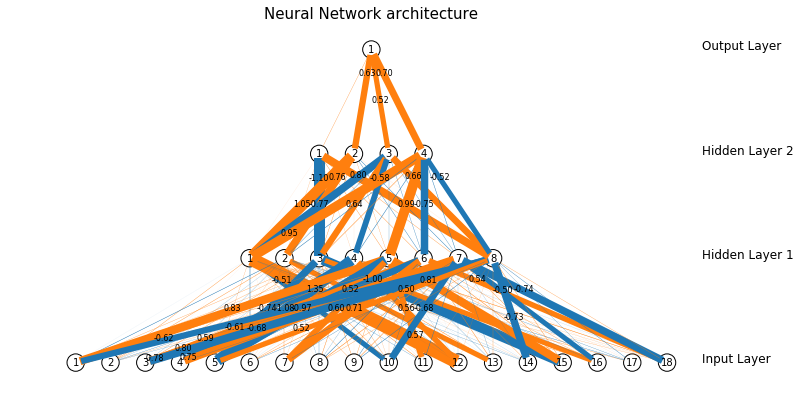

In [77]:
layer_weights = []
network_structure = [x_test.shape[1]]
for layer in model.layers:
    layer_weights.append(layer.get_weights()[0])
    network_structure.append(layer.output_shape[1])
network = VisNN.DrawNN(network_structure, layer_weights)
network.draw()

In [127]:
optimizertest(optimizers=["adam", privateop])

adam test


ValueError: Error when checking input: expected dense_197_input to have shape (19,) but got array with shape (20,)

In [66]:
predictions = model.predict(x_test)
rounded = np.rint(predictions)

#con_mat = tf.confusion_matrix(labels=np.argmax(y_test, axis=1),predictions=np.argmax(predictions, axis=1), num_classes=2, dtype=tf.int32, name=None)
con_mat = tf.confusion_matrix(labels=y_test,predictions=rounded, num_classes=2, dtype=tf.int32, name=None)

with tf.Session():
   print('Confusion Matrix: \n\n', tf.Tensor.eval(con_mat,feed_dict=None, session=None))

Confusion Matrix: 

 [[    0  8159]
 [    0 39049]]


In [93]:
pd.DataFrame(np.vstack(x_test)).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.681351,0.743409,0.540190,0.874897,0.799651,0.173336,0.467772,0.230145,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
1,0.628078,0.559705,0.682216,0.624718,0.603674,0.413931,1.000000,0.337466,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
2,0.596685,0.406042,0.172340,0.522779,0.607149,0.370815,0.000000,0.293985,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0.568980,0.516514,0.256935,0.637618,0.748736,0.392608,0.165746,0.260453,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
4,0.722772,0.632470,0.512951,0.697615,0.708447,0.444522,0.362799,0.368109,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0


In [94]:
data.head()

,tract_to_msamd_income,population,minority_population,number_of_owner_occupied_units,number_of_1_to_4_family_units,loan_amount_000s,hud_median_family_income,applicant_income_000s,property_type_name,owner_occupancy_name,loan_type_name,loan_purpose_name,lien_status_name,co_applicant_sex_name,applicant_sex_name,applicant_race_name_1,applicant_ethnicity_name,agency_abbr,state_abbr_VA,action_taken_name
54053,0.751989,0.531982,0.316884,0.630998,0.731340,0.377679,0.362799,0.273296,1,0,1,0,1,1,0,1,1,1,1,1
2578,0.692363,0.395379,0.307538,0.513794,0.486126,0.278190,1.000000,0.419782,1,1,1,0,0,0,1,1,1,0,1,1
197246,0.642091,0.320156,0.884065,0.422708,0.403436,0.404691,0.362799,0.348163,1,0,1,0,1,0,1,0,1,1,1,0
180923,0.652469,0.572692,0.565375,0.629383,0.620537,0.402802,0.362799,0.326281,1,1,1,0,1,0,1,1,1,1,1,0
187806,0.496619,0.413484,0.443535,0.547983,0.592252,0.413931,1.000000,0.318711,1,1,1,0,1,1,1,1,1,1,1,0
